### Context
From [Anthropic's Toy Models of Superposition](https://transformer-circuits.pub/2022/toy_model/index.html):
- We expect that features that co-occur up to some point will take orthogonal directions (bases) in activation space.
- Two features that do not co-occur will take similar feature bases and can be decoupled with the nonlinear activation function.

On the other hand, from [Anthropic's Toward Monosemanticity](https://transformer-circuits.pub/2023/monosemantic-features#phenomenology-feature-splitting):
- Features which affect the output in the same way will have similar feature directions.

### Planning
Can we examine the similarities of feature directions vs their covariance on typical data and their effect on the overall LLM output?
- What to do about negative covariances?
- Plot the pairwise feature direction similarities versus feature weight covariances.
	- If superposition is purely antipodal, then 0-covariant features will have negative similarities.
		- There will likely be some decrease in feature direction similarity as features get more covariant, up to some threshold, ~~when the features collapse and then they are perfectly aligned.~~
			- Not sure about this actually, because the autoencoder may not be incentivized to find separate features that are similar
		- I think it would be good to analyze both covariance and action similarities

The quantitative results we want:
- feature activation covariances over the entire dataset
	- we'll probably get a memory error when we try to compute this 
	- result will be (feature_activation, feature_activation)
		- n_feature_activations ~= 16000
- feature direction cosine similarities
	- the feature directions are length 1, so this will just be the dot product
- *output similarities* 
	- compute the similarities between the output distributions for each feature
	- ~~KL divergence between output distributions~~
  	  - Actually, we're going to use Jensen-Shannon divergence as it's commutative.
	- vocab size ~48e3
	- we just take the output distributions for those inputs that yield an activation for feature i, then aggregate those distributions (sum or mean)
		- we can just take the mean over probabilities to get the overall probability distribution

### Hypothesis
What relationships do I expect to see?
|                                   | features DO NOT cooccur | features DO cooccur |
| --------------------------------- | ------------------- | ----------------------- |
| **output distribution SIMILAR**   | cos = 1             | cos = 1                 |
| **output distribution DIFFERENT** | cos = -1             | cos = 0                |


# Load data

In [13]:
from utils import cfg
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

data_dir = Path("analysis_data")

torch.set_grad_enabled(False)

In [ ]:
model_name = "first_run"
with open(data_dir / f"{model_name}_feature_correlations.pt", "rb") as f:
    feature_correlations = torch.load(f).cpu().numpy()
print(feature_correlations.shape)
with open(data_dir / f"{model_name}_feature_output_jsd_matrix.pt", "rb") as f:
    feature_output_similarity = 1 - torch.load(f).cpu().numpy()
print(feature_output_similarity.shape)
with open(data_dir / f"{model_name}_cosine_similarities.pt", "rb") as f:
    feature_direction_similarity = torch.load(f).cpu().numpy()
print(feature_direction_similarity.shape)

In [15]:
num_features = cfg.dict_size
triu_indices = np.triu_indices(num_features, k=1)

feature_correlations_flat = feature_correlations[triu_indices]
feature_output_similarity_flat = feature_output_similarity[triu_indices]
feature_direction_similarity_flat = feature_direction_similarity[triu_indices]

print("number of pairs before filtering:", feature_correlations_flat.shape[0])

number of pairs before filtering: 134209536


### Subsample

In [4]:
idx = np.random.choice(feature_correlations_flat.shape[0], int(1e7), replace=False)
feature_correlations_flat_subset = feature_correlations_flat[idx]
feature_output_similarity_flat_subset = feature_output_similarity_flat[idx]
feature_direction_similarity_flat_subset = feature_direction_similarity_flat[idx]
print("number of pairs after filtering:", feature_correlations_flat.shape[0])

number of pairs after filtering: 10000000


## Plot pairwise: feature direction cosine, Jensen-Shannon divergence between outputs, and feature activation correlation

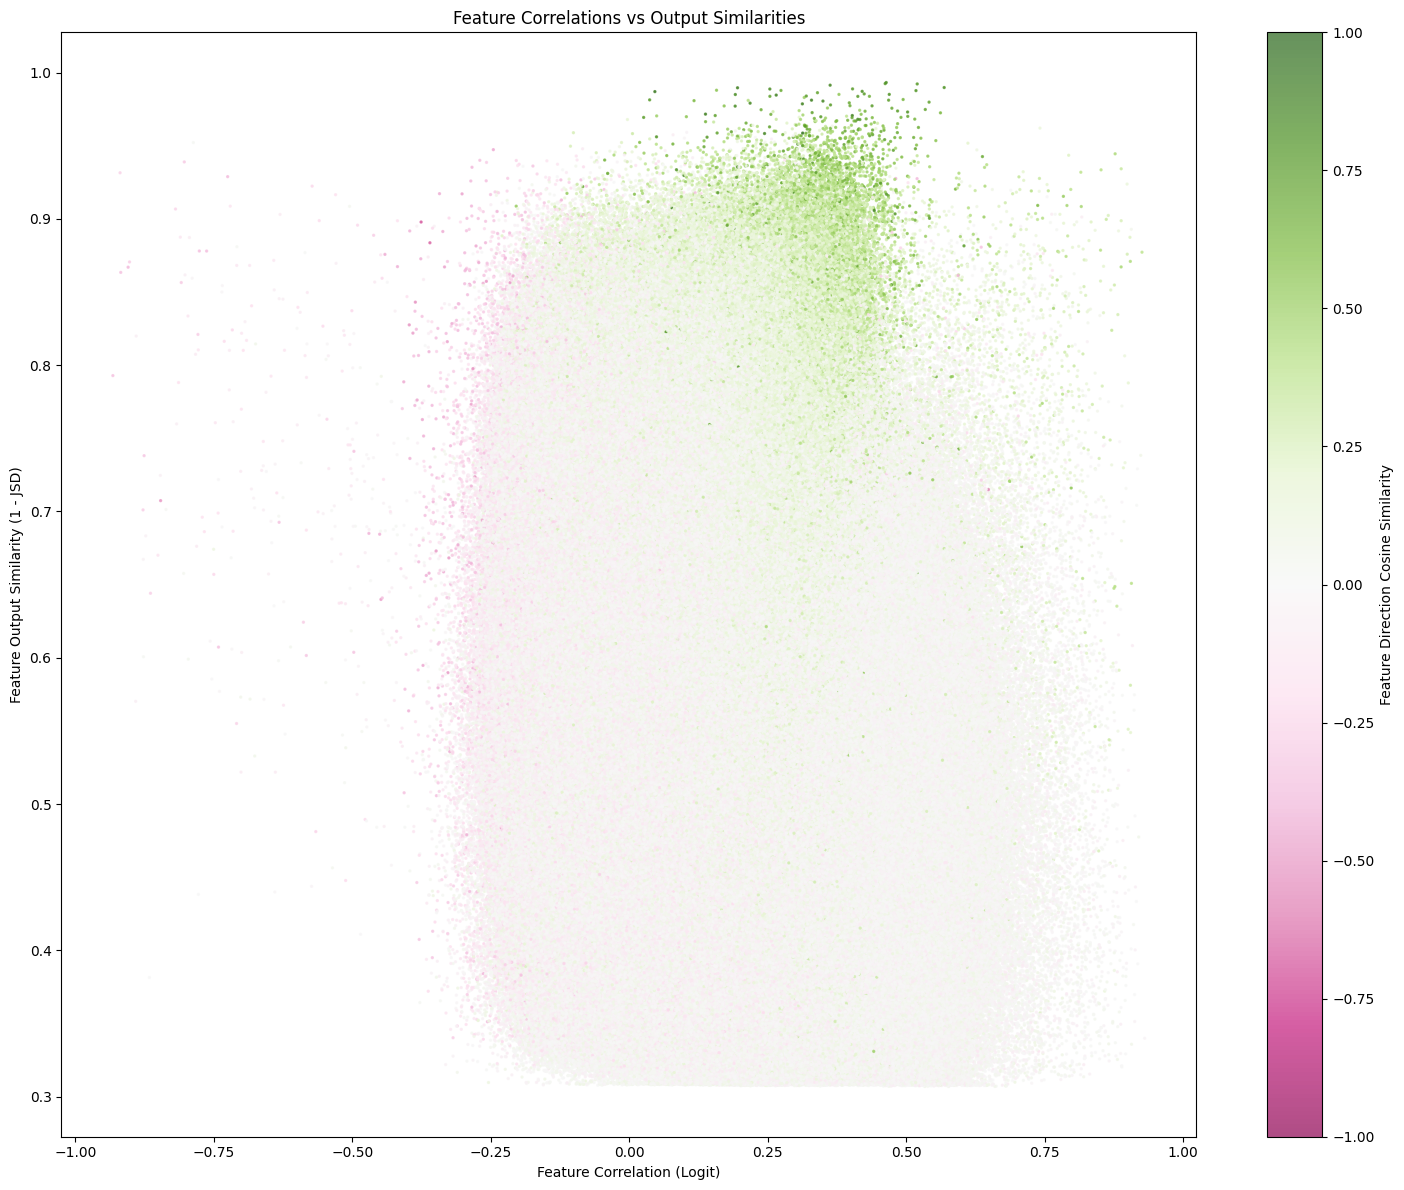

In [5]:
plt.figure(figsize=(15, 12))
ax = plt.scatter(
    x=feature_correlations_flat_subset,
    y=feature_output_similarity_flat_subset,
    c=feature_direction_similarity_flat_subset,
    alpha=0.7,
    s=2,
    cmap="PiYG",
    vmin=-1,
    vmax=1,
)
plt.colorbar(ax, label='Feature Direction Cosine Similarity')
plt.xlabel('Feature Correlation (Logit)')
plt.ylabel('Feature Output Similarity (1 - JSD)')
plt.title('Feature Correlations vs Output Similarities')
plt.tight_layout()
plt.show()

## Analysis
What we actually see is:
|                                   | features DO NOT cooccur | features DO cooccur |
| --------------------------------- | ------------------- | ----------------------- |
| **output distribution SIMILAR**   | cos = -1            | cos = 1                 |
| **output distribution DIFFERENT** | cos = -1            | cos = 0                |

This makes some sense:
- If two features cooccur but yield different outputs, they must take mutually orthogonal bases to avoid interference.
- If two features cooccur and have the same output, then they can take a similar basis because it's okay to have interference between them (as they both yield the same output).
- If two features do not cooccur, then they can share a basis (superposition), such as by forming [antipodal pairs](https://transformer-circuits.pub/2022/toy_model/index.html#geometry-uniform).

What's still a bit confusing:
- Why do we see such a big splotch of orthogonal feature directions? There can only be so many orthogonal pairs, which is why we see superposition in the first place. Maybe, our analysis needs to be more sensitive to small alignments / antialignments.
- Why would the model choose to use superposition for features that do not cooccur, but cause the same output? Although superposition saves capacity, it costs even fewer parameters to just share the exact same basis (i.e. with the same sign too).

### Zooming in on correlated features

In [9]:
## Only correlated features
idx = feature_correlations_flat > 0.35
feature_correlations_flat_subset = feature_correlations_flat[idx]
feature_output_similarity_flat_subset = feature_output_similarity_flat[idx]
feature_direction_similarity_flat_subset = feature_direction_similarity_flat[idx]

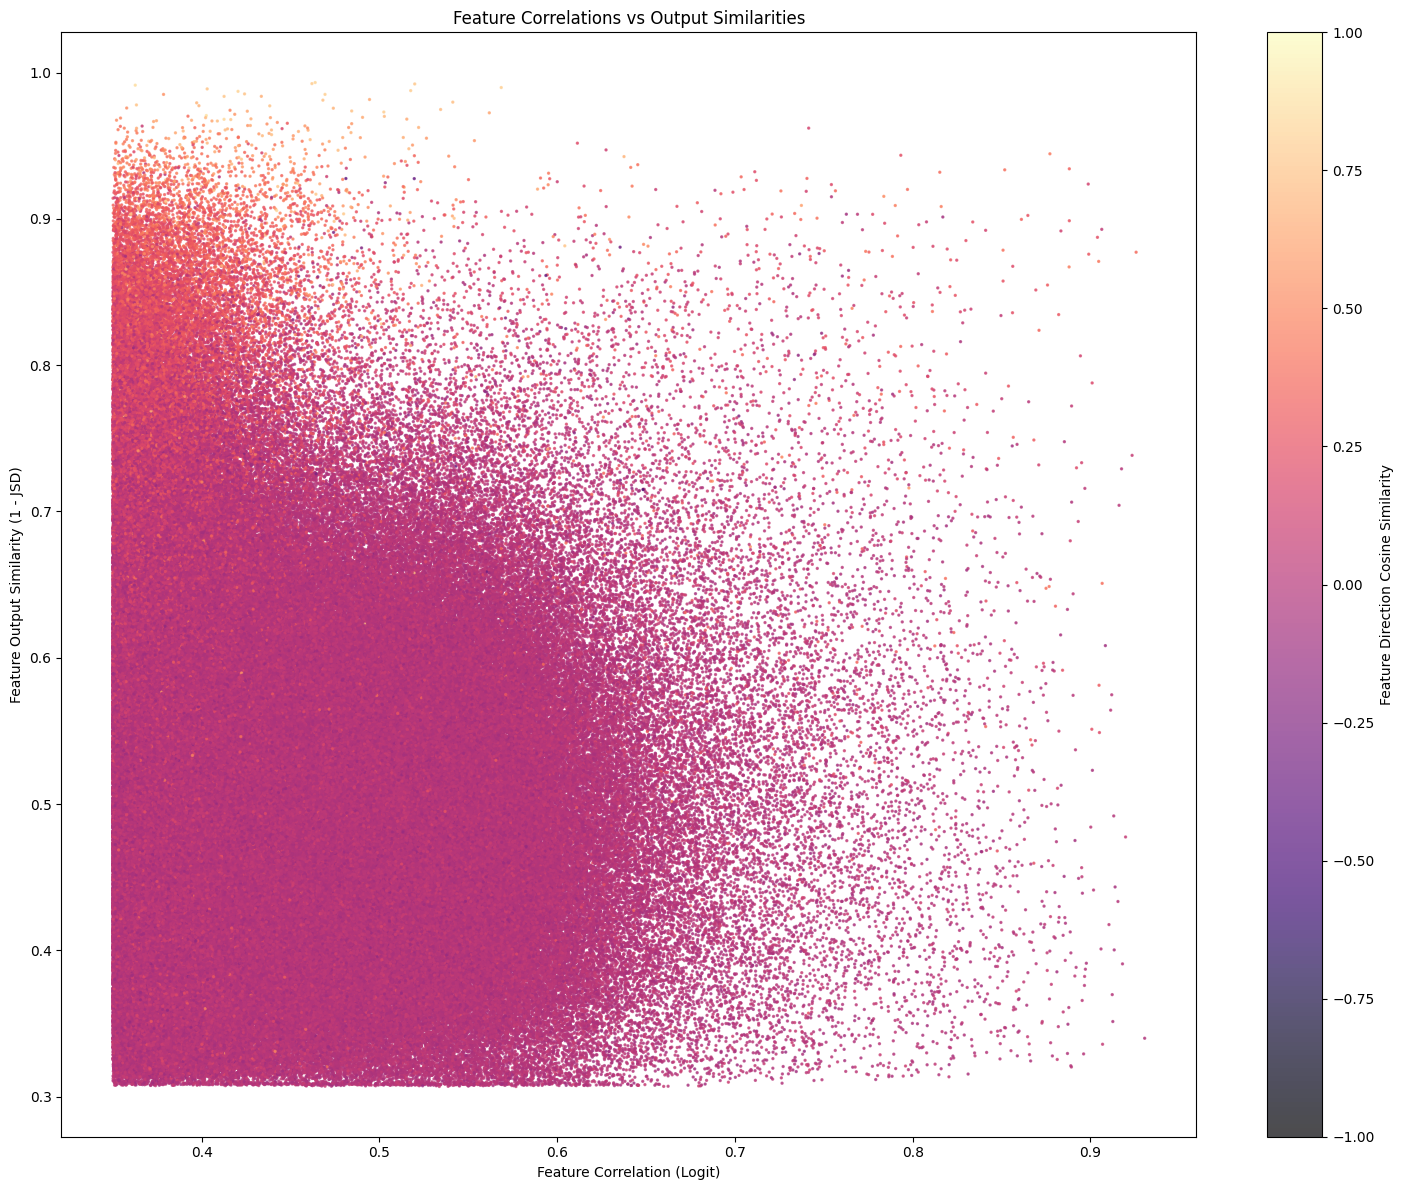

In [10]:
plt.figure(figsize=(15, 12))
ax = plt.scatter(
    x=feature_correlations_flat_subset,
    y=feature_output_similarity_flat_subset,
    c=feature_direction_similarity_flat_subset,
    alpha=0.7,
    s=2,
    cmap="magma",
    vmin=-1,
    vmax=1,
)
plt.colorbar(ax, label='Feature Direction Cosine Similarity')
plt.xlabel('Feature Correlation (Logit)')
plt.ylabel('Feature Output Similarity (1 - JSD)')
plt.title('Feature Correlations vs Output Similarities')
plt.tight_layout()
plt.show()